# Module 5 Assignment

## Structural Models

1. Computation of the firms asset value of $V_0$ and volatility $\sigma_E$:

Given:

$D_0$ = 5

$E_0$ = 3

$\sigma_E$ = 0.5

T = 1

rr = 0.02

Using the Black-Scholes formula we know that:

$E_0\ =\ V_0 N(d_1)\ - \ De^{-rT}N(d_2)$

applying Ito's lemma to obtain another condition that must be satisifed by $V_0$ and $\sigma_v$

$\sigma_E E_0 = N(d1)\sigma_V V_0$

we now have a set of non-linear equations that we can solve using Excel. 

http://cqf.morphean.co.uk/notebooks/

Producing the following results

## Credit Curve



| Maturity | $\lambda$ | DF Z(0;T) | CDS DB EUR |
|----------|---------|-----------|--|
| 1Y       | 0.00995 | 0.97      |141.76|
| 2Y       | 0.02087 | 0.94      |165.36|
| 3Y       | 0.02579 | 0.92      |188.56|
| 4Y | - | - | 207.32 |
| 5Y | - | - | 218.38 |

<center>Hazard Rates and Spreads for DB</center>

1. Given the term structure of hazard rates and discounting factors, interpolate to quaterly increments $\Delta t = 0.25$ and price the CDS with accruals on the assumpton of flat spread for all tenors. $RR = 40\%$. You will have to create PL and CL computation for each quarterly period and use Solver to find the spread.

In [1]:
from numpy import linspace

# given in basis points
dbSpread = [141.76,165.36,188.56,207.32,218.38]

# get range of timesteps at 0.25 increments
timesteps = linspace(0,3,13)
print timesteps

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.  ]


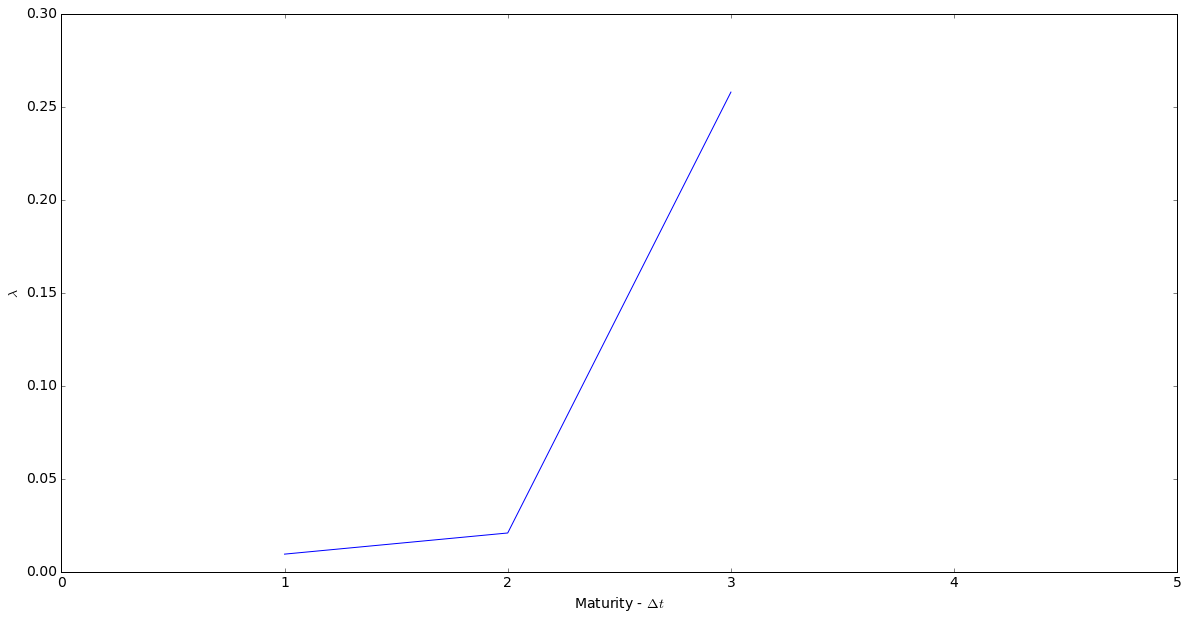

In [2]:
discountFactors = [0.97,0.94,0.92]

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline
from numpy import linspace, array, arange, exp, log

# for colour cycling in graphs
from itertools import cycle
cycol = cycle('bgrcmyk').next

# set defaults for charts
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 14.0

x = [1,2,3]
y = [0.0095,0.02087,0.2579]

plt.plot(x,y)
plt.xlim(0,5)
plt.xlabel('Maturity - $\Delta t$')
plt.ylabel('$\lambda$')


We need to interpolate the hazards rates into $\Delta t$ of 0.25.

In [3]:
from numpy import arange, logspace, array, delete, exp

hzrd = [0.0095,0.02087,0.2579]

# linear interpolation 
interpolatedHzrd = array([ linspace(point, hzrd[index+1],5) for index, point in enumerate(hzrd[:2]) ])
hzrdInt = delete(interpolatedHzrd.flatten(),4)
hzrdInt

array([ 0.0095   ,  0.0123425,  0.015185 ,  0.0180275,  0.02087  ,
        0.0801275,  0.139385 ,  0.1986425,  0.2579   ])

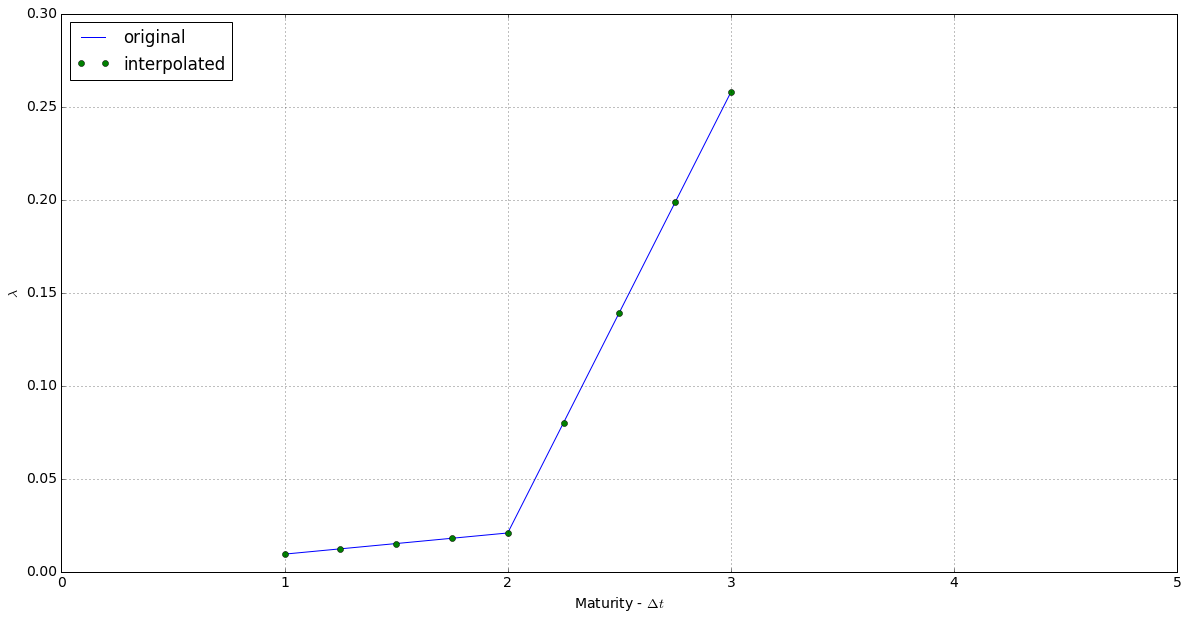

In [4]:
x = [1,2,3]
y = [0.0095,0.02087,0.2579]

plt.plot(x,y, label='original')
plt.xlim(0,5)
plt.plot(linspace(1,3,9), hzrdInt, 'o', label='interpolated')
plt.xlabel('Maturity - $\Delta t$')
plt.ylabel('$\lambda$')
plt.legend(loc='upper left')
plt.grid()

Pricing the CDS with Accruals, we will use the following formula:

$PL_N=S_N\ \sum_{n=1}^N D(0,T_n)P(T_n)(\Delta t_n) + S_N \ \sum_{n=1}^N D(0,T_n)(P(T_{n-1})-P(T_n))\frac{\Delta t}{2}$

and the following methods:

In [5]:
from numpy import put, zeros

# nominal value to price the premium (spread)
n=1

# we can imply the survival probability from the hazard rate / (1-hzrdRate)
pSurv = [1-p for p in hzrdInt]
recoveryRate = 0.4

def calculatePremiumLegValues(notional=float,
                              discountFactors=list, 
                              probSurv=list,
                              probDefault=list, 
                              lamda=list,
                              seed=float('nan'),
                              deltaT=float,
                              withAccruals=False):
    """
    returns the list of the premium leg values
    :return: array
    """
    #          assume 1%
    values = zeros(len(self.timesteps))
    for index, (df, pt, pd, l) in enumerate(zip(discountFactors, pT, pD, lamda)):
        if index > 0:
            pv = (notional * deltaT * df * pt) * (l if isnan(seed) else seed)
            if withAccruals:
#               $ +D(0,T_n)(P(T_{n-1}) - P(T_n)) \frac{\Delta t_n}{2} $
                pv += pd * Dt * 0.5
                                                  
                        
            put(values, index, pv)
    return values

def calculateDefaultLegValues(notional=float,
                              timesteps=list,
                              discountFactors=list,
                              probDefault=list,
                             recoveryRate=float):
    """
    returns the list of the default leg values
    :return: array
    """
    #          assume 1%
    values = zeros(len(self.timesteps))
    for index, (df, pd) in enumerate(zip(discountFactors, probDefault)):
        if index > 0:
            value = notional * (1 - recoveryRate) * df * pd
            put(values, index, value)
    return value


### 2. Bootstrap implied survival probabilities

Bootstrap implied survival probabilities for DB with recovery rate $RR=40\%$ on the assumption that the premium paid annually in arrears (no accruals), default payment made at the end of one year period. Use continuous DF consistent with risk free rate of 0.8%

In [6]:
# bootstrap implied survival probability
def bootstrapSurvivalProbability(recovery=float, spreads=list, timesteps=list, discountFactors=list):
    # P(t_0) = 1
    pS = [1.0]
    L = 1 - recovery
    for index, (spread, timestep, d) in enumerate(zip(spreads, timesteps, discountFactors)):
        # note the zero offset here for year indices vs array indicies
        if index == 0:
            result = L / (L + timestep * spread)
        if index > 1:
            iM1=index-1
            result = (discountFactors[iM1] * (L - (L + timesteps[iM1] * spread) * pS[iM1]) / d * (L + timestep * spread)) \
                     + (pS[iM1] * L) / (L + timestep * spread)
        pS.append(result)
    return pS

def genDiscountFactorForContinousRate(r=float, t=float):
    return exp(-t*r)

In [7]:
discountFactors2 = [genDiscountFactorForContinousRate(0.008, year) for year in range(1,6)]

print 'Discount Factors'
print '================'
print discountFactors2

Discount Factors
[0.99203191483706066, 0.98412732005528514, 0.97628570975790929, 0.9685065820791976, 0.96078943915232318]


In [8]:
scaledSpreads = [a/10000. for a in dbSpread]

impliedSurvivalProbabilities = bootstrapSurvivalProbability(recovery=0.4, 
                                                            spreads=scaledSpreads, 
                                                            timesteps=[1,2,3,4,5], 
                                                            discountFactors=discountFactors2)

print 'Implied Survival Probabilities'
print '=============================='
print impliedSurvivalProbabilities

Implied Survival Probabilities
[1.0, 0.9769186682644715, 0.9769186682644715, 0.8775326173503385, 0.82599676384543375, 0.74015494454902919]


### 3. Obtain term structure for hazard rates

Obtain the term structure of hazard rates for Db and plot the exponent

In [1]:
xdata = range(1,6)
ydata = hTS
plt.plot(xdata,ydata, '-',color=cycol(), label='$\lambda$')
plt.plot(xdata, ydata, 'ro',c=cycol(), ms=5, label='Smoothed Hazard Curve')
spl = UnivariateSpline(xdata, ydata)
xs = linspace(min(xdata), len(xdata), 1000)
spl.set_smoothing_factor(0.5)
plt.plot(xs, spl(xs),':k', c=cycol(), lw=2)
steppedRange = [hTS[0],hTS[0],hTS[1],hTS[1],hTS[2],hTS[2],hTS[3],hTS[3],hTS[4],hTS[4]]
stepCol = cycol()
plt.step(range(1,3),steppedRange[0:2], 'ro',color=stepCol)
plt.step(range(2,4),steppedRange[2:4], 'ro',color=stepCol)
plt.step(range(3,5),steppedRange[4:6], 'ro',color=stepCol)
plt.step(range(4,6),steppedRange[6:8], 'ro',color=stepCol)
plt.plot(range(1,6),hTS, 'ro',color=cycol(), label='$\lambda$')
expPdf = [l*exp(-l*t) for l,t in zip(hTS,timesteps)]
plt.plot(range(1,6))
plt.xlim(0,6)
plt.ylim(-0.02)
plt.xlabel('Maturity - $\Delta t$')
plt.ylabel('$\lambda$')
plt.legend(loc='upper left')
plt.grid()
plt.title('Hazard Term Structure')

NameError: name 'hTS' is not defined

At T2 we see a shock event, potentially the fallout from the Brexit referendum. Now that we have all the methods in place, 

In [ ]:
Now all t

In [3]:
def getHazardTermStructure(survProbabilities=list, timesteps=list, deltaT=float):
    hzdTS = []
    for step in timesteps:
        result = (-1/deltaT)*log((survProbabilities[step])/survProbabilities[step-1])
        hzdTS.append(result)
    return hzdTS

hTS = getHazardTermStructure(impliedSurvivalProbabilities,range(1,6),1.0)

print 'Hazard Term Structure'
print '====================='
print hTS

NameError: name 'impliedSurvivalProbabilities' is not defined